In [19]:
%ls

Makefile                          mlir_files/
README.md                         python/
Report.md                         results_scalar/
Untitled.ipynb                    results_vector/
all_results_scalar.csv            scalar_pipeline.sh*
all_results_vector/               src/
analysis_output/                  stride_comparison.png
analysis_output_stride1/          stride_grouped_analysis/
folder_structure.txt              vector_performance_dashboard.png
jupiter/                          vector_pipeline.sh*
matrices/


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
import re


# Directory principale contenente le sottocartelle
directory = "results_vector"  # Cartella principale

# Lista per contenere i dataframe da tutti i file
all_dataframes = []

# Leggi tutti i file CSV dalle sottocartelle
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    
    # Verifica che sia una directory e non un file
    if os.path.isdir(subdir_path):
        print(f"Analisi della sottocartella: {subdir}")
        
        # Lista per contenere i dataframe della sottocartella corrente
        subdir_dataframes = []
        
        # Estrai la dimensione del vettore dal nome della sottocartella
        vector_size_match = re.search(r"results_vector_(\d+)", subdir)
        vector_size = int(vector_size_match.group(1)) if vector_size_match else None
        
        # Leggi tutti i file CSV nella sottocartella
        for filename in os.listdir(subdir_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(subdir_path, filename)
                print(f"  Elaborazione file: {filename}")
                
                try:
                    df = pd.read_csv(filepath)
                    
                    # Standardizza le colonne
                    df.columns = ['Value', 'Unit', 'Metric', 'Percentage', 'Count', 'Total', 'Rate', 'Description']
                    df.replace('', pd.NA, inplace=True)
                    df.dropna(subset=['Value'], inplace=True)
                    df['Value'] = pd.to_numeric(df['Value'])
                    df['Rate'] = pd.to_numeric(df['Rate'])
                    
                    # Aggiungi indice fittizio per il pivot
                    df['DummyIndex'] = range(len(df))
                    
                    # Pivot del DataFrame
                    df_pivot = df.pivot(index='DummyIndex', columns='Metric', values='Value')
                    df_pivot = df_pivot.reset_index(drop=True)
                    df_pivot.columns.name = None
                    
                    # Rinomina le metriche per maggiore chiarezza
                    translation_dict = {
                        'task-clock': 'Task Clock',
                        'context-switches': 'Context Switch',
                        'cpu-migrations': 'CPU Migration',
                        'page-faults': 'Page Faults',
                        'cycles': 'Cycles',
                        'instructions': 'Instructions',
                        'branches': 'Branches',
                        'branch-misses': 'Branch Misses'
                    }
                    df_pivot.rename(columns=translation_dict, inplace=True)
                    
                    # Estrai sparsity e stride dal nome del file
                    match = re.search(r"sparsity_(\d+)_stride_(\d+)", filename)
                    if match:
                        sparsity = int(match.group(1))
                        stride = int(match.group(2))
                    else:
                        sparsity = None
                        stride = None
                    
                    # Aggiungi i dati estratti al DataFrame
                    df_pivot['Executable'] = os.path.splitext(filename)[0]
                    df_pivot['Sparsity Level'] = sparsity
                    df_pivot['Stride'] = stride
                    df_pivot['Vector Size'] = vector_size  # Aggiungi la dimensione del vettore
                    
                    subdir_dataframes.append(df_pivot)
                    all_dataframes.append(df_pivot)
                except Exception as e:
                    print(f"  Errore nell'elaborazione del file {filename}: {e}")
        
        # Crea un file CSV per la sottocartella corrente
        if subdir_dataframes:
            # Unisci tutti i DataFrame della sottocartella
            subdir_df = pd.concat(subdir_dataframes, ignore_index=True)
            
            # Ordina il DataFrame per executable
            subdir_df_sorted = subdir_df.sort_values(by=['Executable'])
            
            # Reimposta l'indice
            subdir_df_sorted = subdir_df_sorted.reset_index(drop=True)
            
            # Salva il DataFrame in un file CSV specifico per la sottocartella
            subdir_csv_name = f"all_results_vector/all_{subdir}.csv"
            subdir_df_sorted.to_csv(subdir_csv_name)
            
            print(f"File CSV creato per la sottocartella {subdir}: {subdir_csv_name}")

# Crea un file CSV complessivo con tutti i dati
if all_dataframes:
    # Unisci tutti i DataFrame in uno
    final_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Ordina il DataFrame per dimensione del vettore e poi per nome dell'eseguibile
    final_df_sorted = final_df.sort_values(by=['Vector Size', 'Executable'])
    
    # Reimposta l'indice
    final_df_sorted = final_df_sorted.reset_index(drop=True)
    
    # Salva il DataFrame in un file CSV complessivo
    all_csv_name = f"all_results_vector/all_{directory}.csv"
    final_df_sorted.to_csv(all_csv_name)
    
    print(f"File CSV complessivo creato: {all_csv_name}")
else:
    print("Nessun dato trovato nelle cartelle specificate.")

Analisi della sottocartella: results_vector_32
  Elaborazione file: results_vector_mlir_sparsity_55_stride_1.csv
  Elaborazione file: results_vector_mlir_sparsity_55_stride_3.csv
  Elaborazione file: results_vector_mlir_sparsity_55_stride_2.csv
  Elaborazione file: results_vector_mlir_sparsity_70_stride_2.csv
  Elaborazione file: results_vector_mlir_sparsity_65_stride_3.csv
  Elaborazione file: results_vector_mlir_sparsity_65_stride_2.csv
  Elaborazione file: results_vector_mlir_sparsity_70_stride_3.csv
  Elaborazione file: results_vector_mlir_sparsity_70_stride_1.csv
  Elaborazione file: results_vector_mlir_sparsity_65_stride_1.csv
  Elaborazione file: results_vector_mlir_sparsity_90_stride_1.csv
  Elaborazione file: results_vector_mlir_sparsity_85_stride_1.csv
  Elaborazione file: results_vector_mlir_sparsity_90_stride_2.csv
  Elaborazione file: results_vector_mlir_sparsity_85_stride_3.csv
  Elaborazione file: results_vector_mlir_sparsity_85_stride_2.csv
  Elaborazione file: results_

Found CSV files: ['all_results_vector/all_results_vector_4.csv', 'all_results_vector/all_results_vector_16.csv', 'all_results_vector/all_results_vector_32.csv', 'all_results_vector/all_results_vector_8.csv']

Processing all_results_vector/all_results_vector_4.csv (Vector Size: 4)
Loading all_results_vector/all_results_vector_4.csv...
Data Shape: (217, 13)
Sparsity Levels: [np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95)]
Strides: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Processed metrics saved to analysis_vector_4/processed_metrics_vector_4.csv


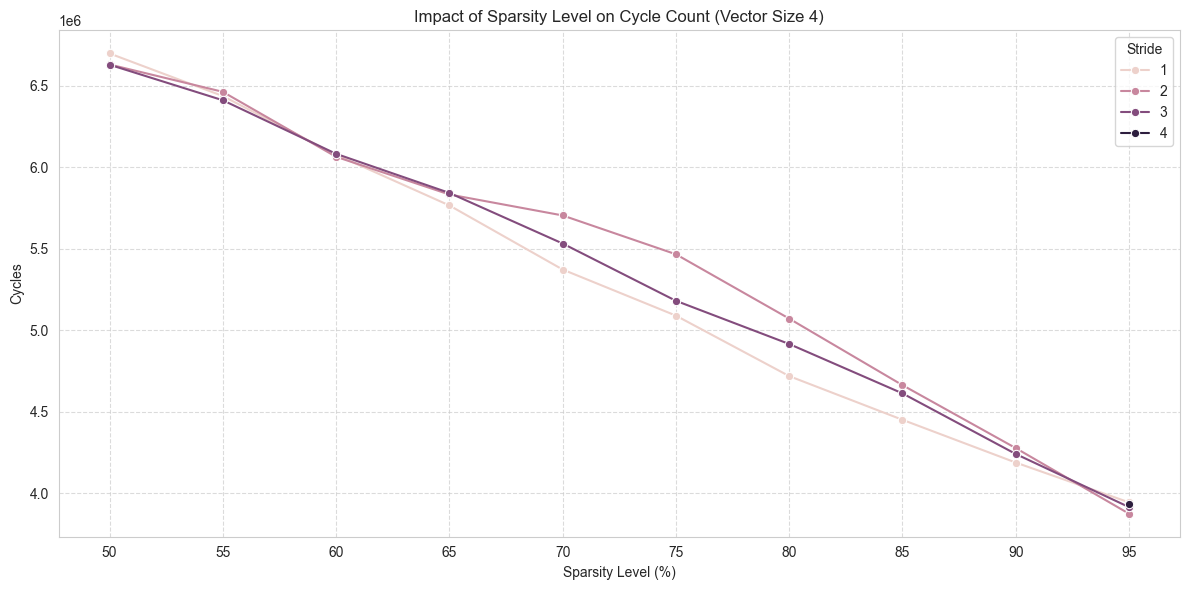

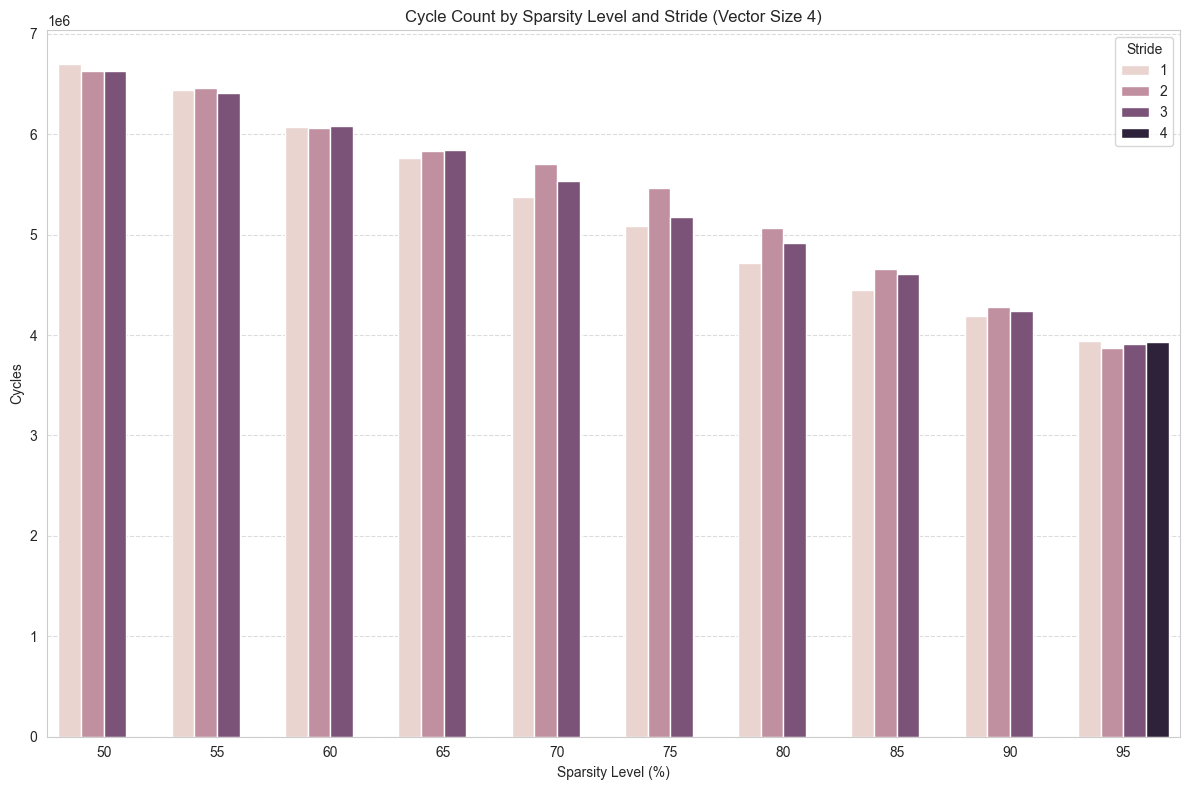

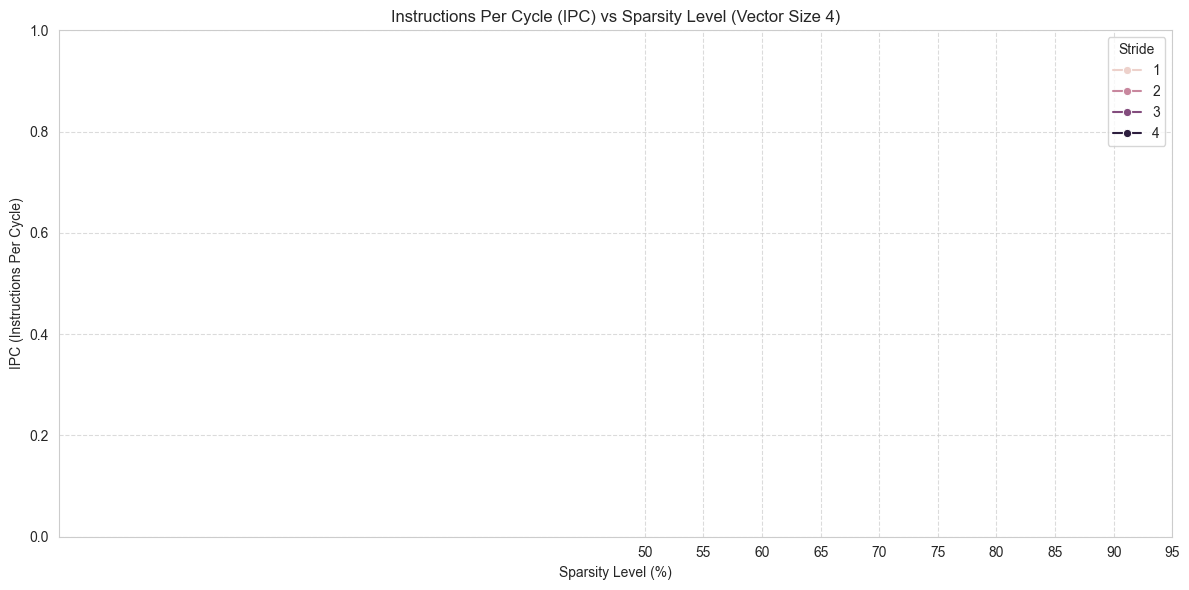

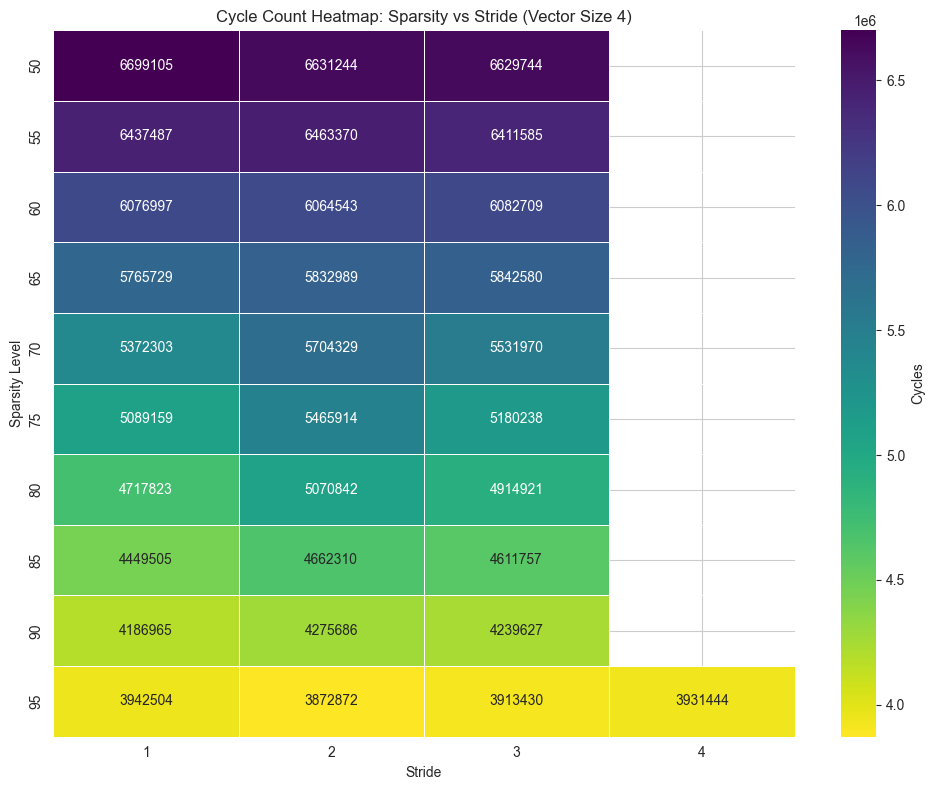

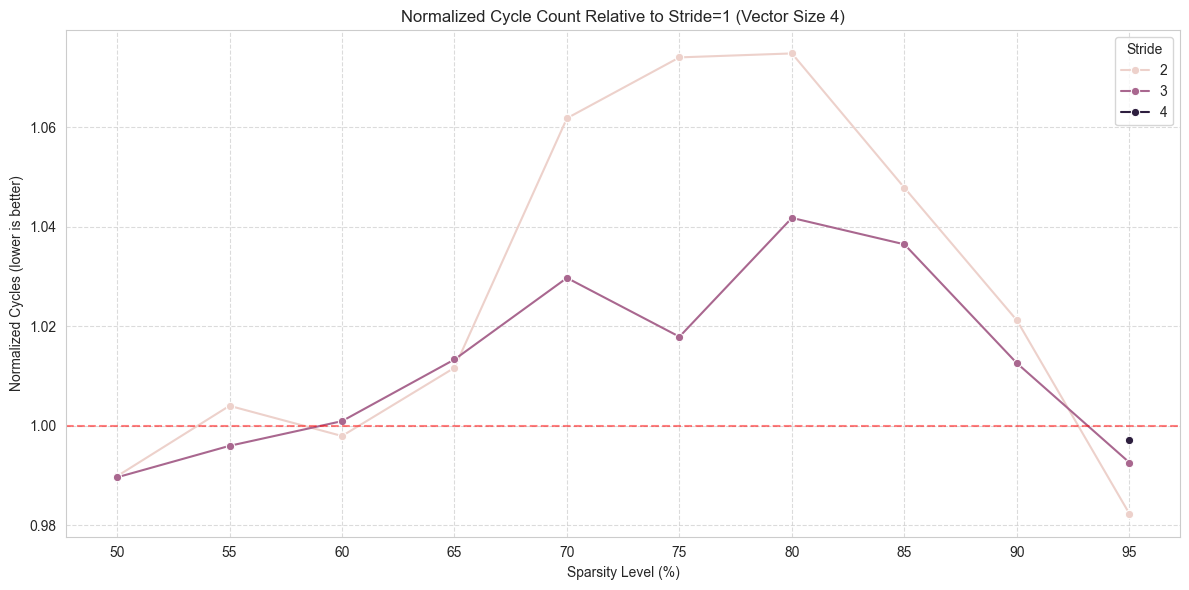

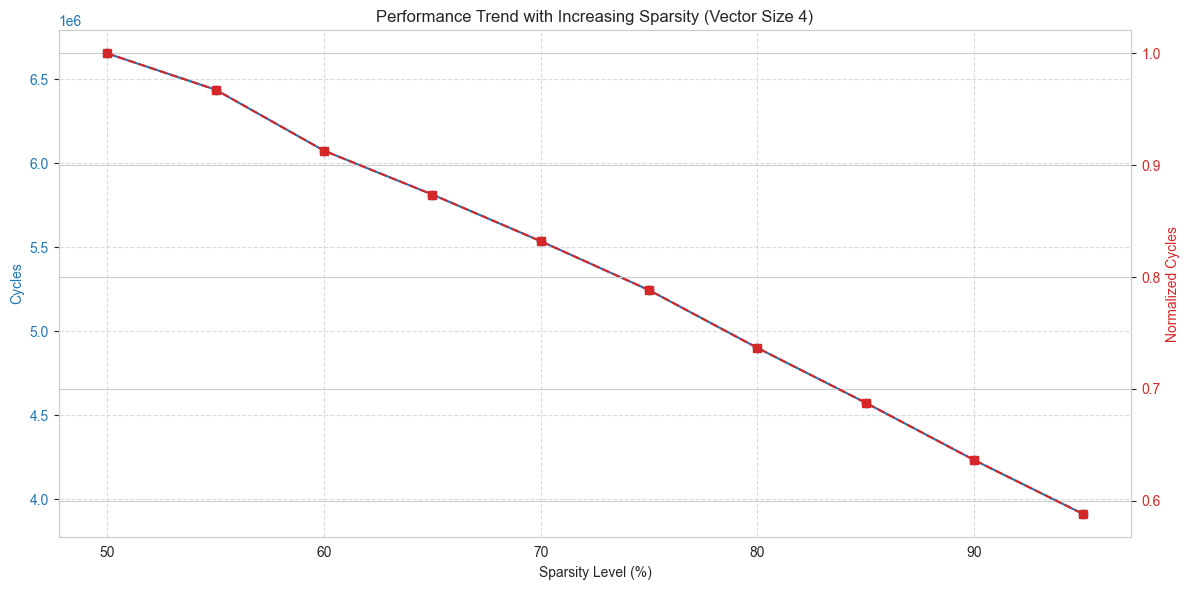

Analysis for Vector Size 4 completed!
Results saved to directory: analysis_vector_4

Conclusions:
1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count decreases by 41.2%
2. Impact of Stride (compared to Stride=1):
   - Stride=2: 2.5% increase in cycles
   - Stride=3: 1.2% increase in cycles
   - Stride=4: -25.5% decrease in cycles
3. Best Configuration: Sparsity=95.0%, Stride=2.0, Cycles=3872872
4. Worst Configuration: Sparsity=50.0%, Stride=1.0, Cycles=6699105

--------------------------------------------------------------------------------

Processing all_results_vector/all_results_vector_16.csv (Vector Size: 16)
Loading all_results_vector/all_results_vector_16.csv...
Data Shape: (217, 13)
Sparsity Levels: [np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95)]
Strides: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Processed metrics saved to analysis_vector_16/processed_

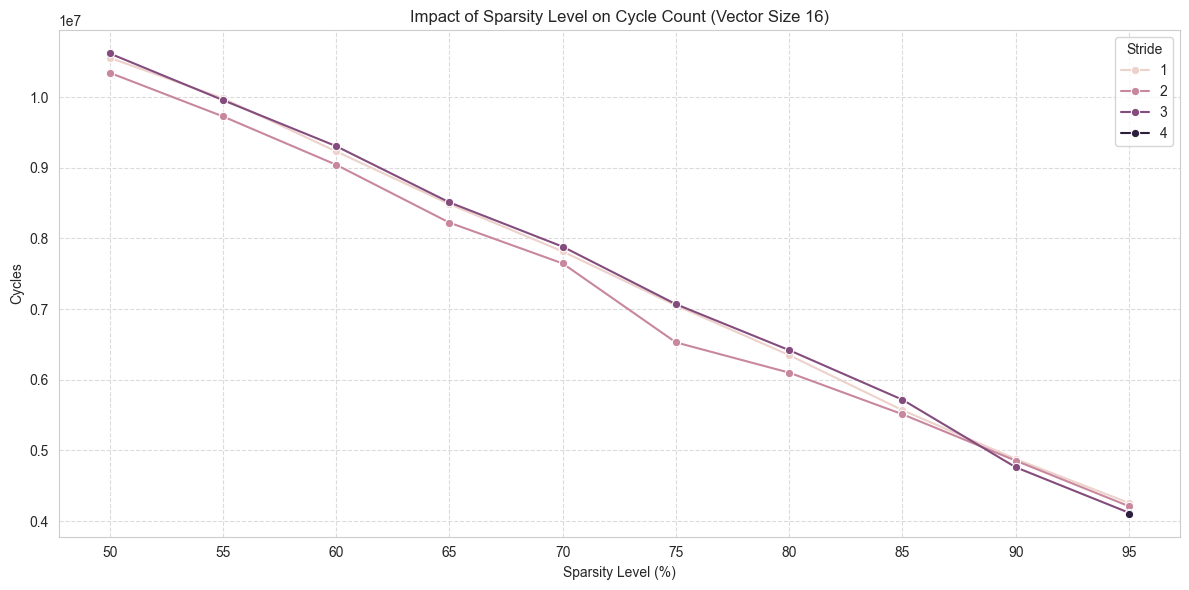

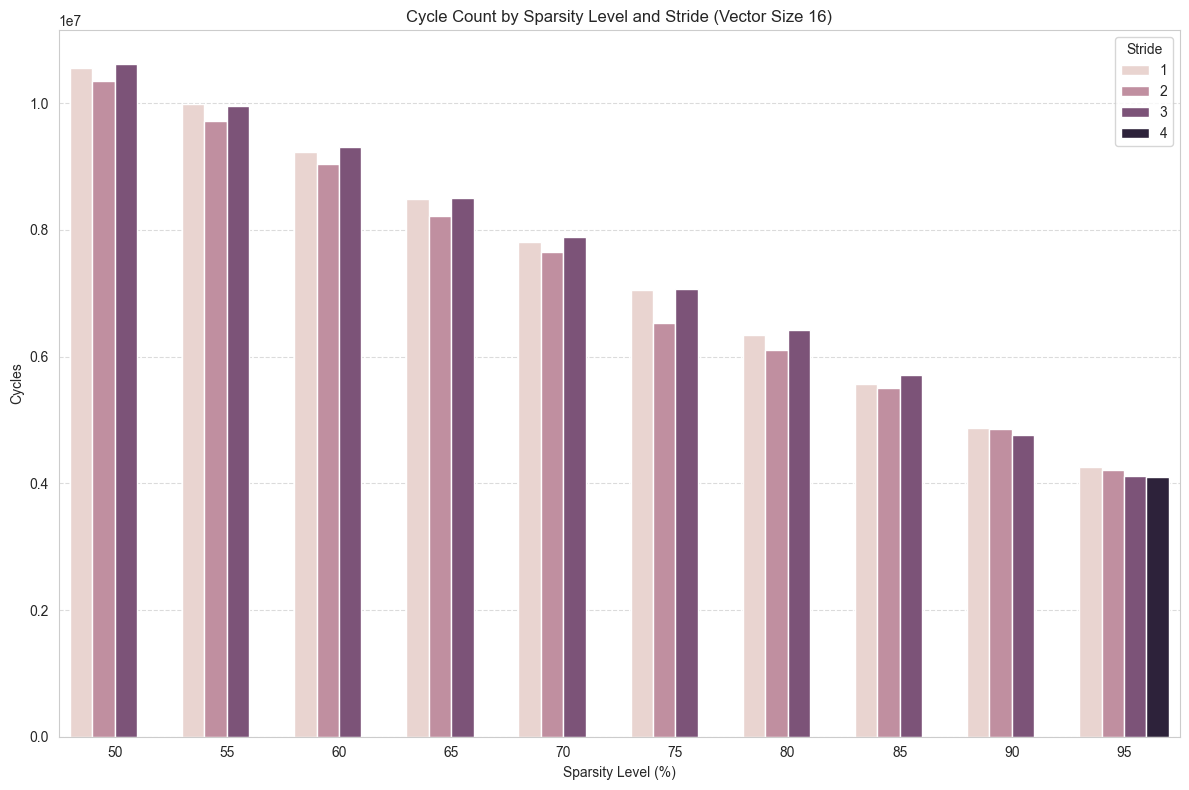

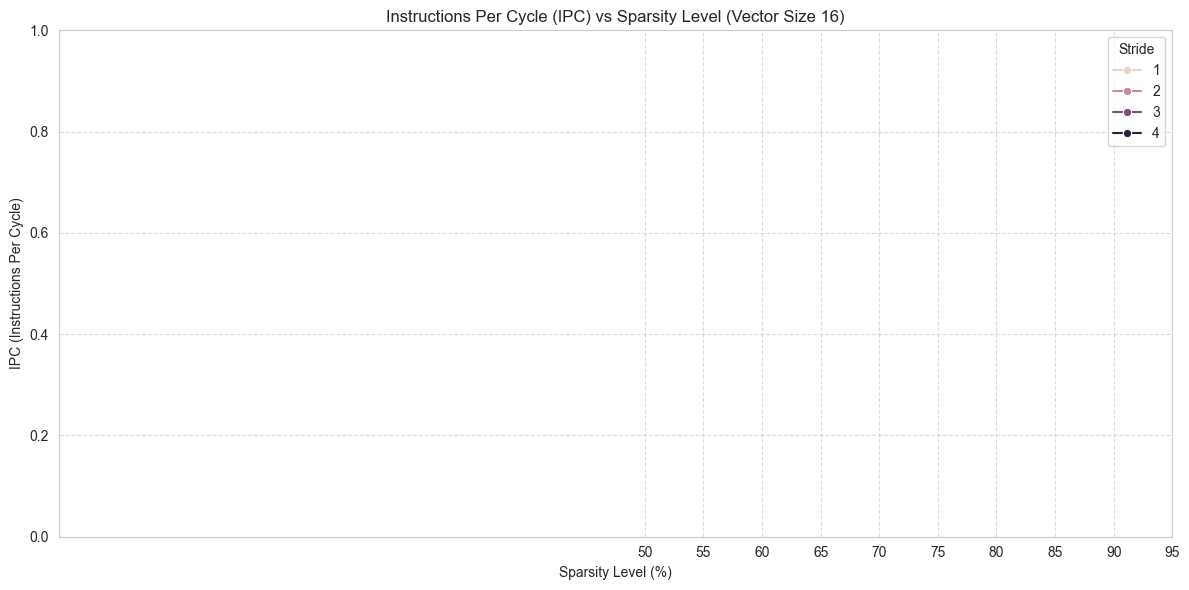

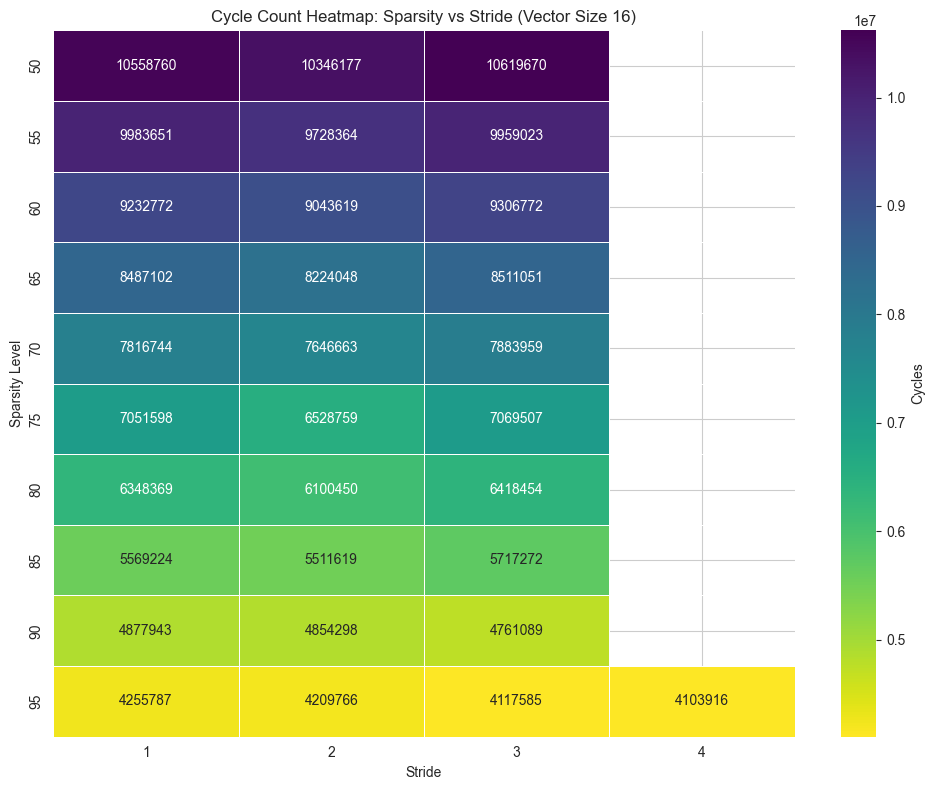

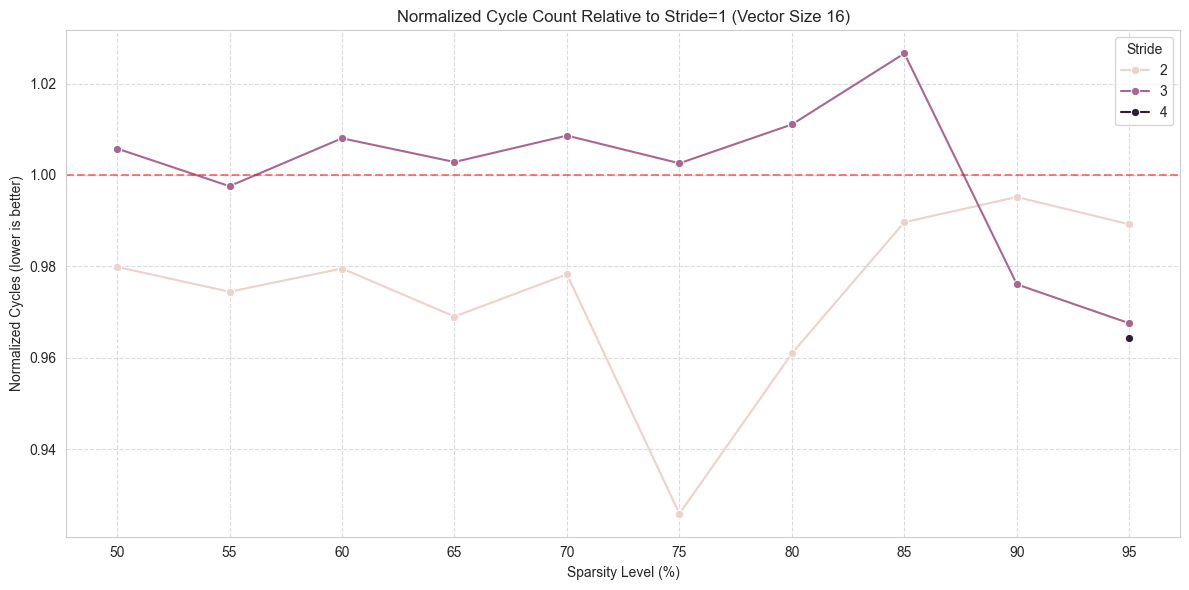

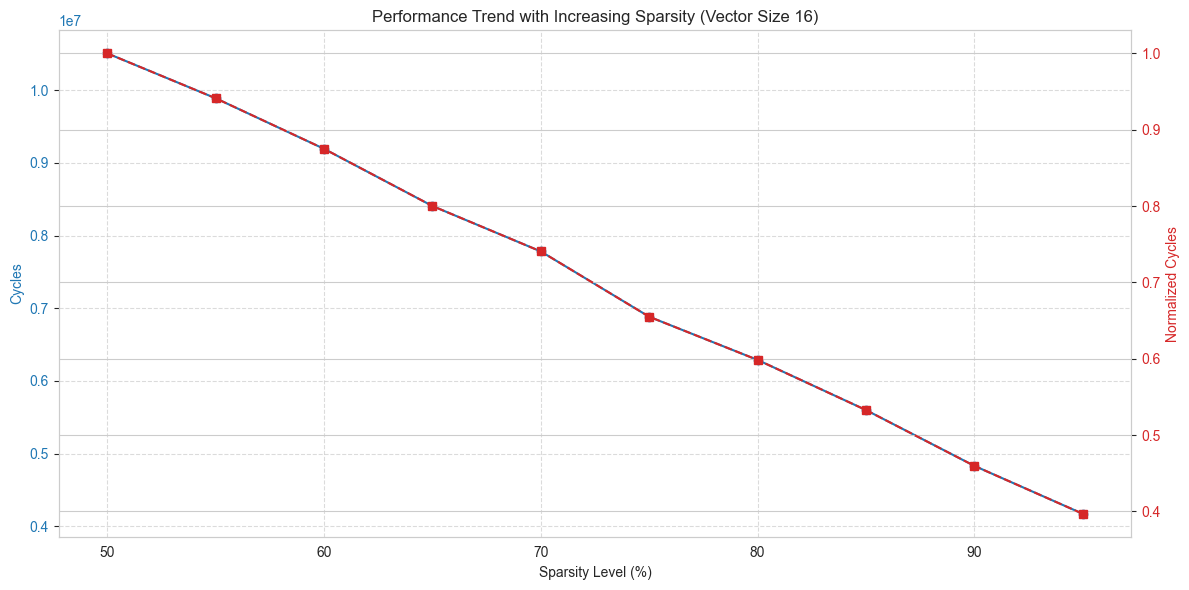

Analysis for Vector Size 16 completed!
Results saved to directory: analysis_vector_16

Conclusions:
1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count decreases by 60.3%
2. Impact of Stride (compared to Stride=1):
   - Stride=2: -2.7% decrease in cycles
   - Stride=3: 0.2% increase in cycles
   - Stride=4: -44.7% decrease in cycles
3. Best Configuration: Sparsity=95.0%, Stride=4.0, Cycles=4103916
4. Worst Configuration: Sparsity=50.0%, Stride=3.0, Cycles=10619670

--------------------------------------------------------------------------------

Processing all_results_vector/all_results_vector_32.csv (Vector Size: 32)
Loading all_results_vector/all_results_vector_32.csv...
Data Shape: (217, 13)
Sparsity Levels: [np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95)]
Strides: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Processed metrics saved to analysis_vector_32/proces

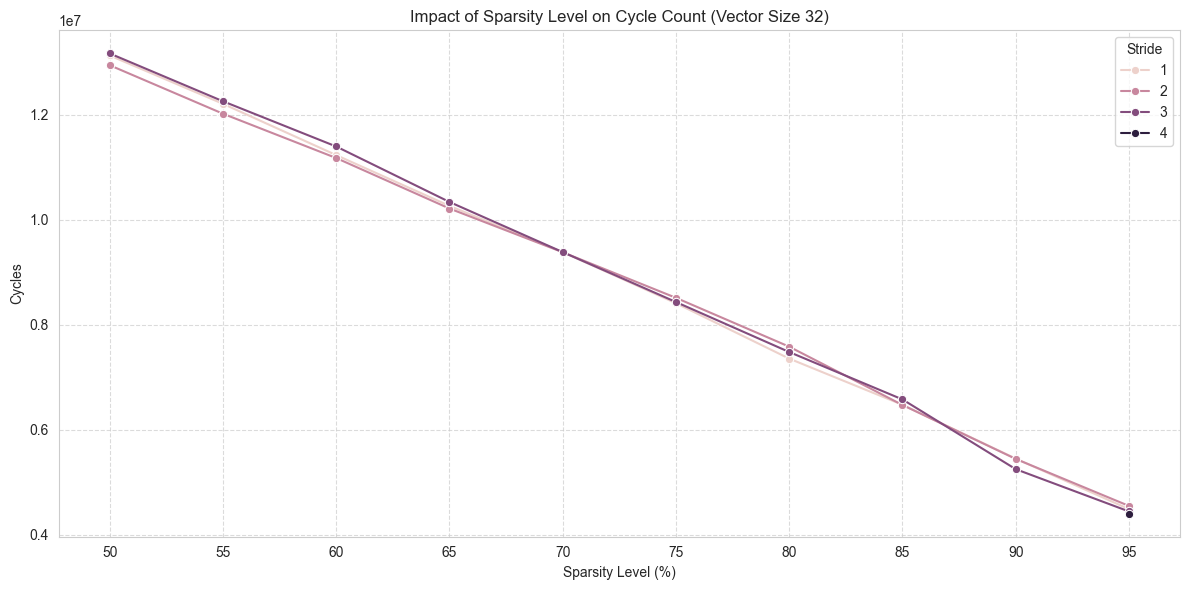

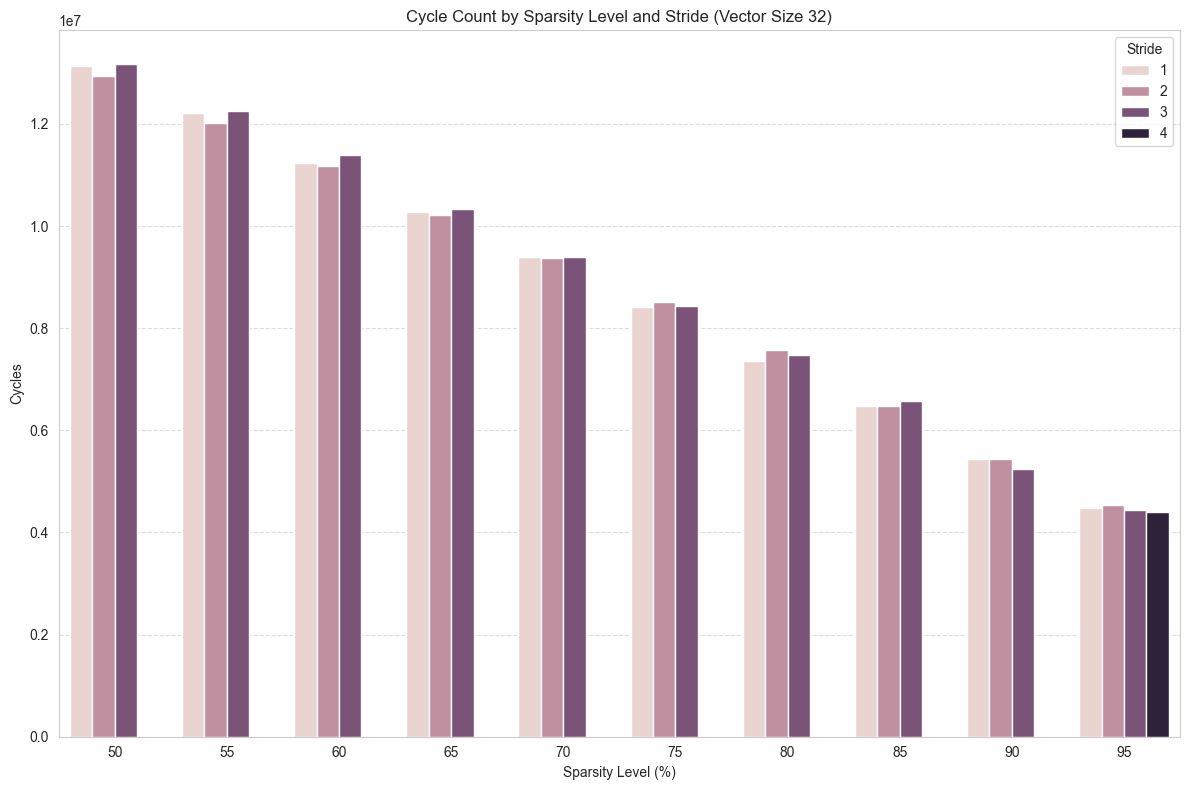

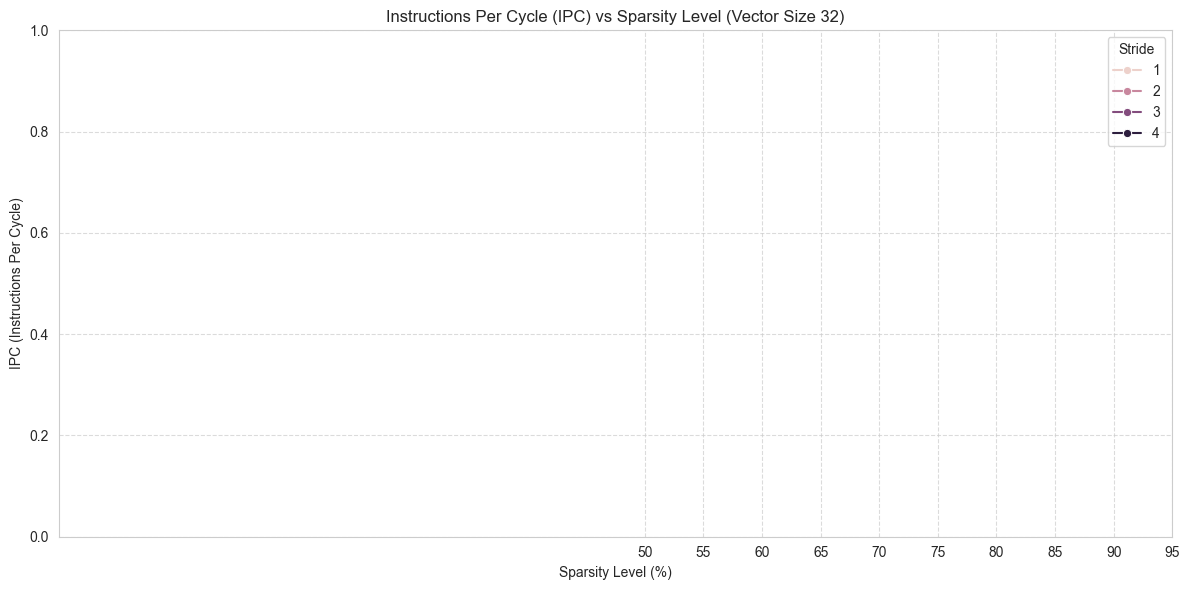

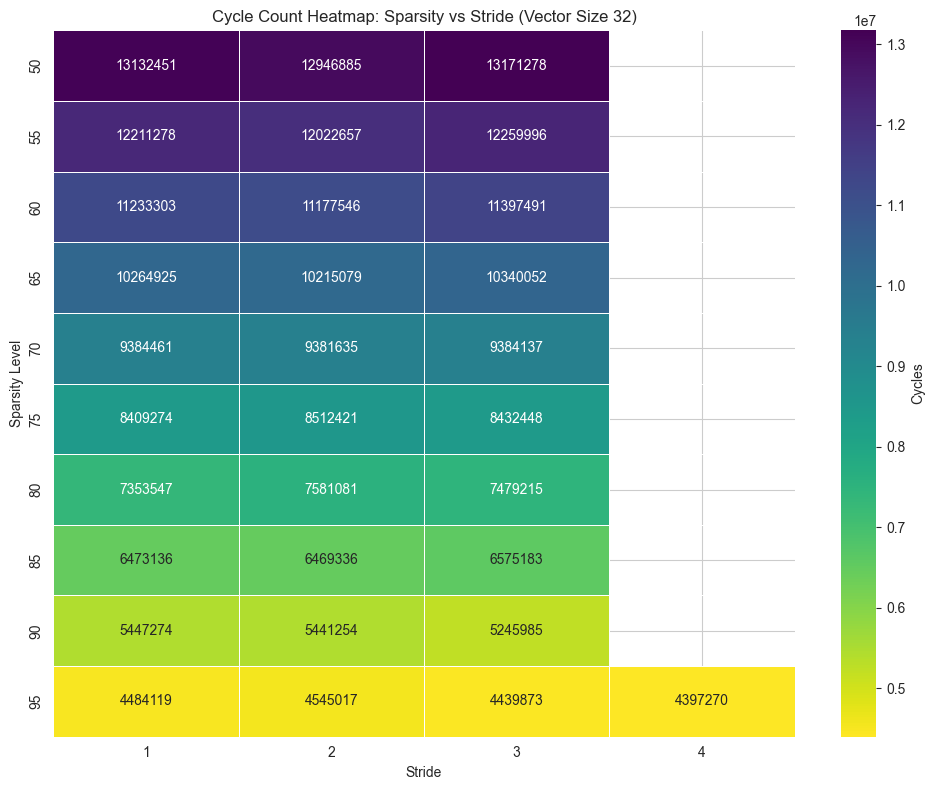

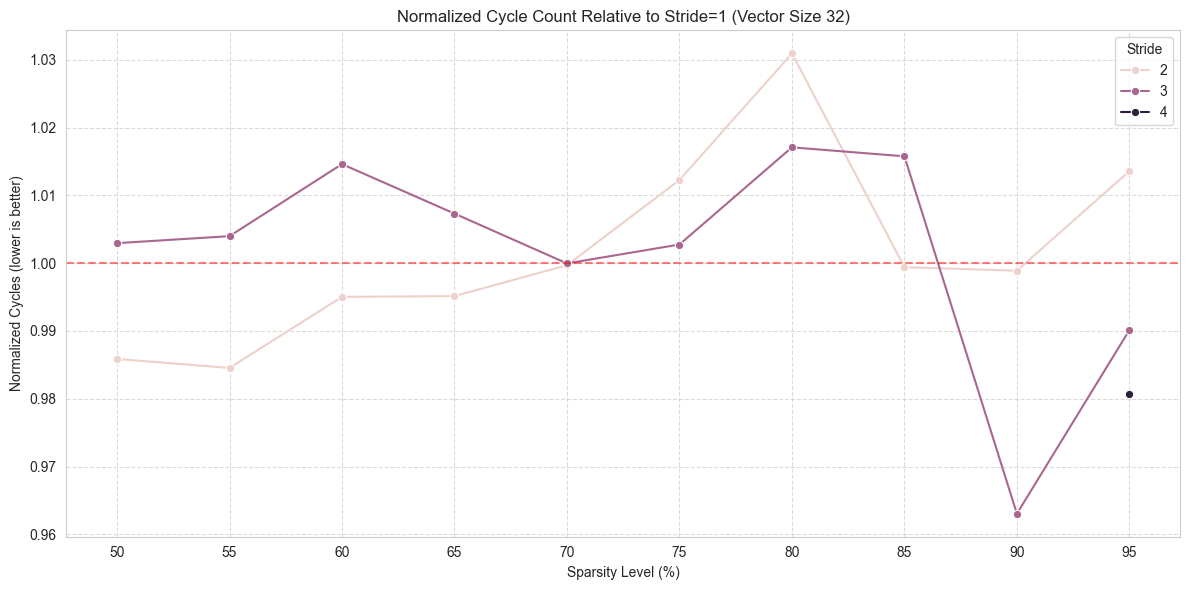

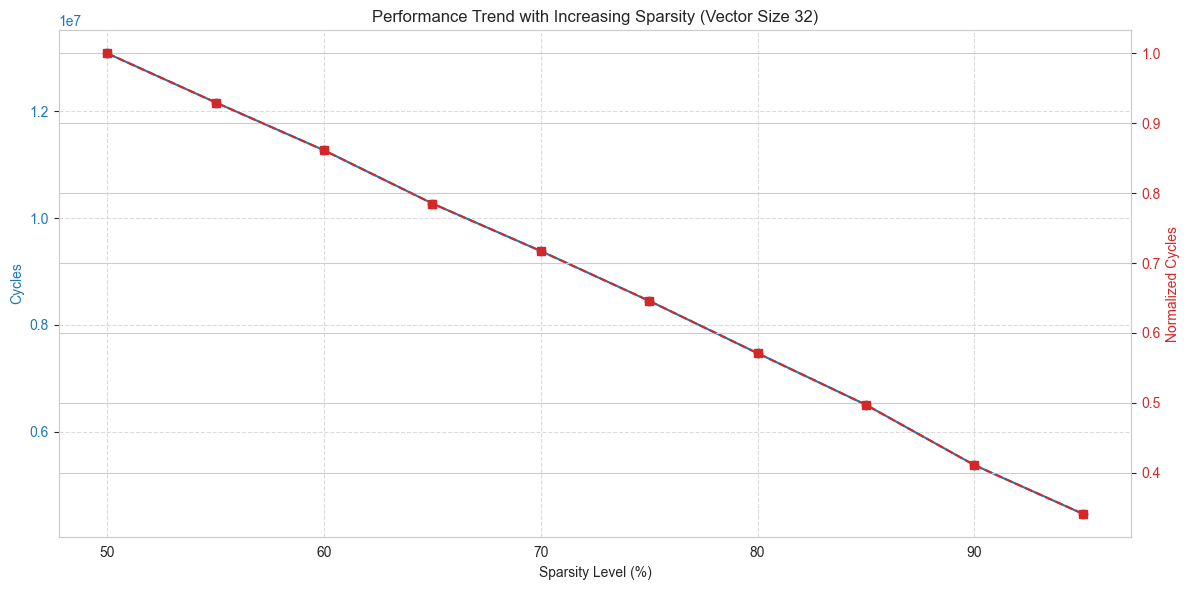

Analysis for Vector Size 32 completed!
Results saved to directory: analysis_vector_32

Conclusions:
1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count decreases by 65.9%
2. Impact of Stride (compared to Stride=1):
   - Stride=2: -0.1% decrease in cycles
   - Stride=3: 0.4% increase in cycles
   - Stride=4: -50.3% decrease in cycles
3. Best Configuration: Sparsity=95.0%, Stride=4.0, Cycles=4397270
4. Worst Configuration: Sparsity=50.0%, Stride=3.0, Cycles=13171278

--------------------------------------------------------------------------------

Processing all_results_vector/all_results_vector_8.csv (Vector Size: 8)
Loading all_results_vector/all_results_vector_8.csv...
Data Shape: (217, 13)
Sparsity Levels: [np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95)]
Strides: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Processed metrics saved to analysis_vector_8/processed_

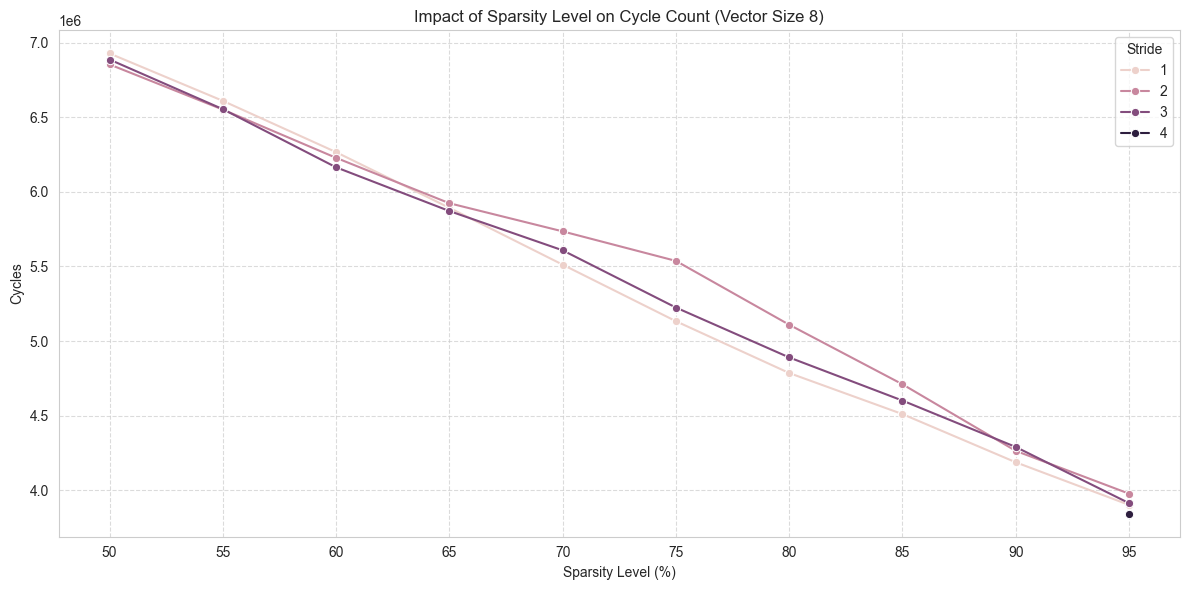

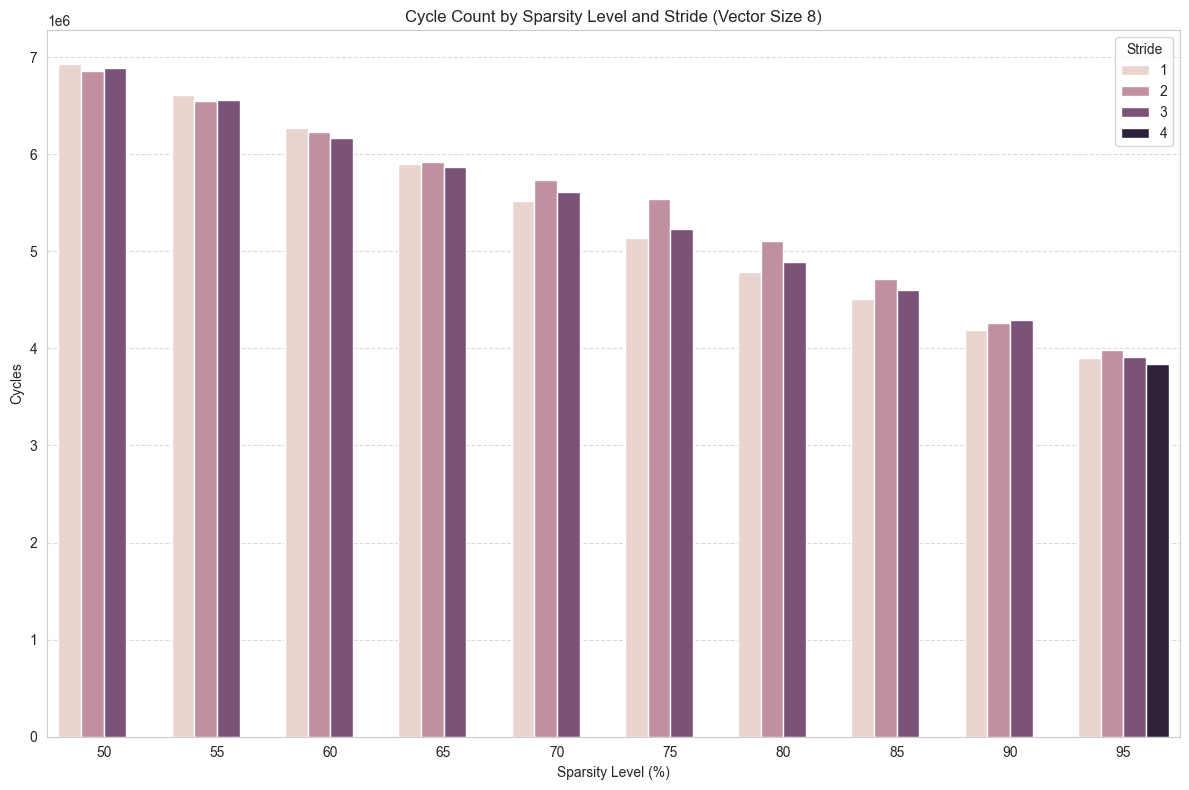

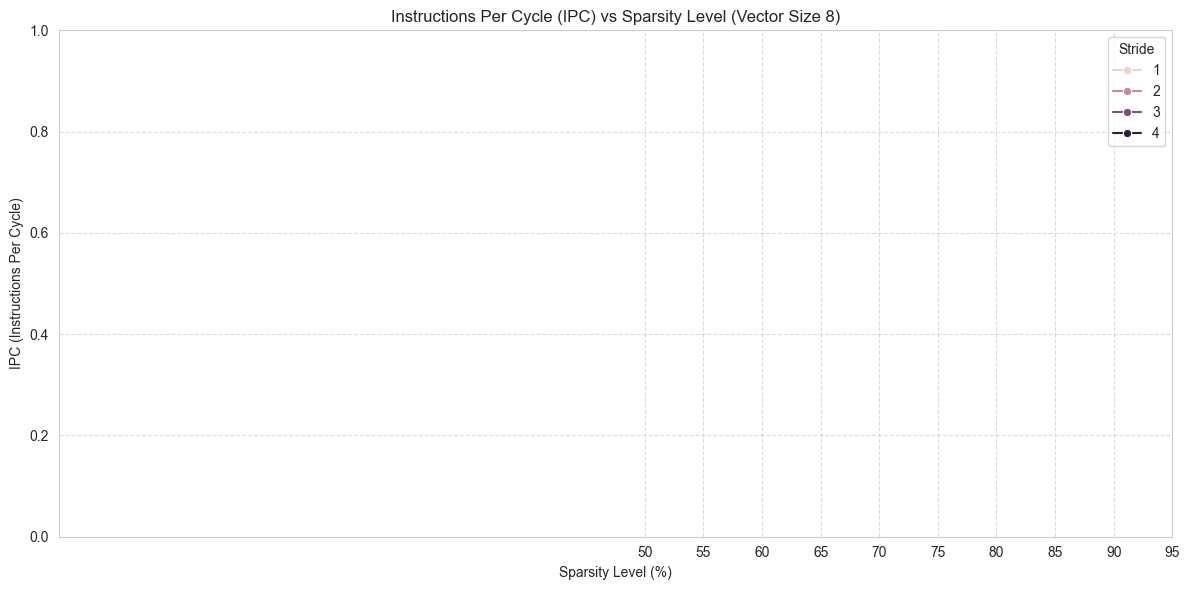

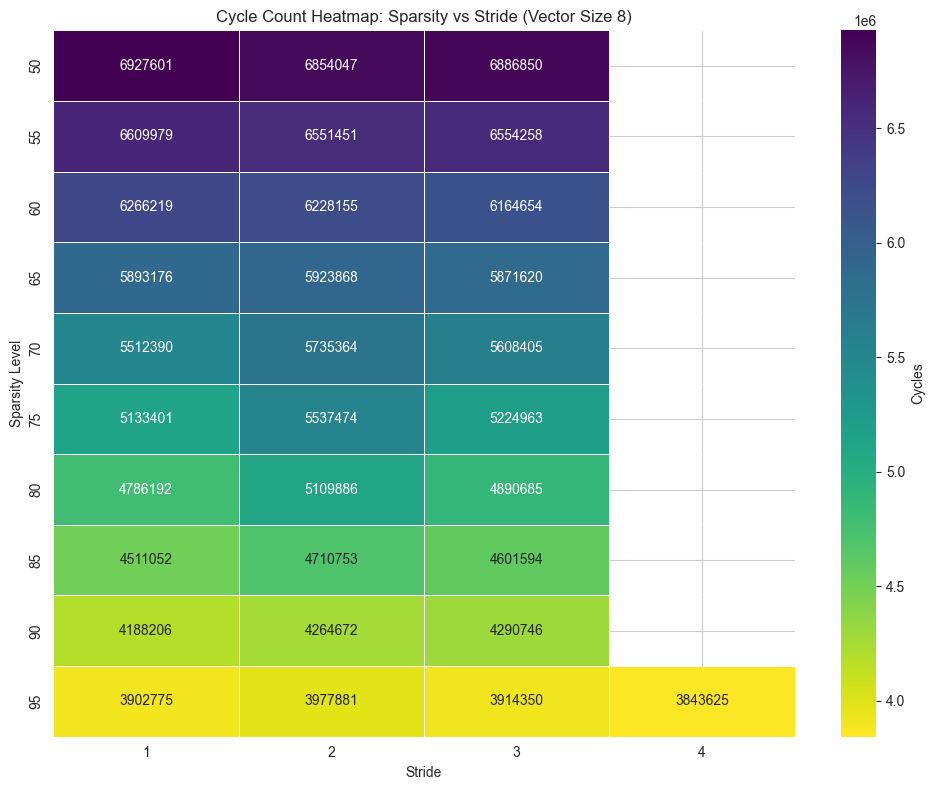

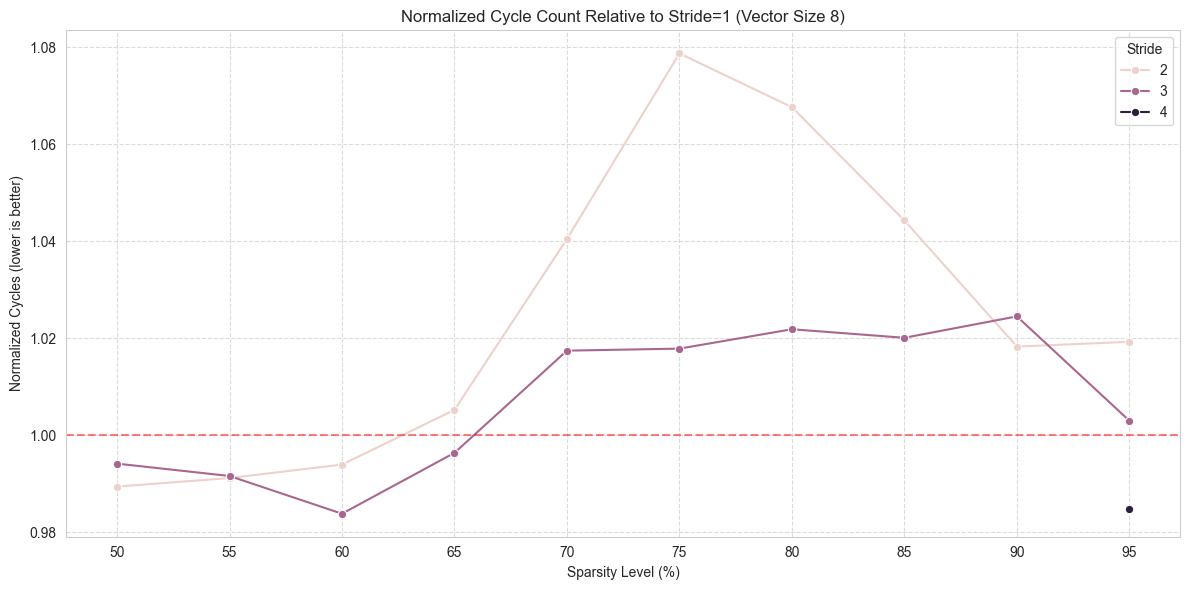

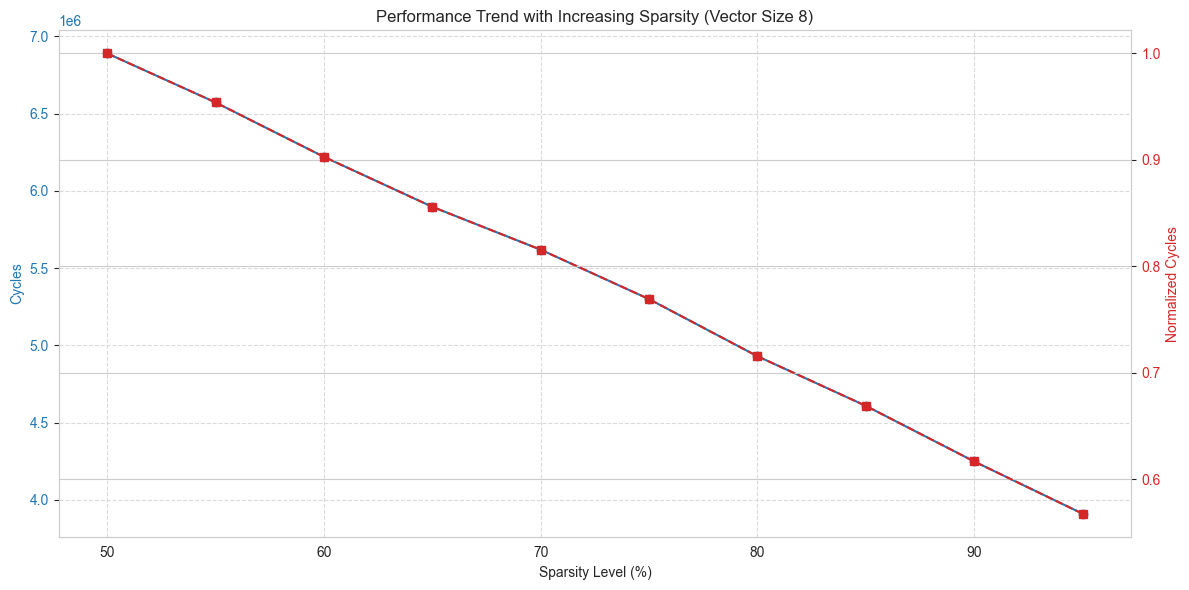

Analysis for Vector Size 8 completed!
Results saved to directory: analysis_vector_8

Conclusions:
1. Impact of Sparsity: As sparsity increases (from 50% to 95%), cycle count decreases by 43.3%
2. Impact of Stride (compared to Stride=1):
   - Stride=2: 2.2% increase in cycles
   - Stride=3: 0.5% increase in cycles
   - Stride=4: -28.5% decrease in cycles
3. Best Configuration: Sparsity=95.0%, Stride=4.0, Cycles=3843625
4. Worst Configuration: Sparsity=50.0%, Stride=1.0, Cycles=6927601

--------------------------------------------------------------------------------


In [28]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to process and plot data for a specific vector size
def process_vector_data(df, vector_size, output_dir):
    # Display basic information
    print(f"Data Shape: {df.shape}")
    print(f"Sparsity Levels: {sorted(df['Sparsity Level'].unique())}")
    print(f"Strides: {sorted(df['Stride'].unique())}")
    
    # Aggregate the data
    metrics_df = df.groupby(['Sparsity Level', 'Stride']).agg({
        'Cycles': 'mean',
        'Instructions': 'mean',
        'Branch Misses': 'mean',
        'Branches': 'mean',
        'IPC': 'mean'
    }).reset_index()
    
    # Sort for better visualization
    metrics_df = metrics_df.sort_values(['Sparsity Level', 'Stride'])
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the processed metrics to CSV
    metrics_csv = os.path.join(output_dir, f"processed_metrics_vector_{vector_size}.csv")
    metrics_df.to_csv(metrics_csv)
    print(f"Processed metrics saved to {metrics_csv}")
    
    # Set seaborn style for better looking plots
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    
    # Analysis 1: Impact of Sparsity Level on Cycle Count
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Sparsity Level', y='Cycles', data=metrics_df, hue='Stride', marker='o')
    plt.title(f'Impact of Sparsity Level on Cycle Count (Vector Size {vector_size})')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Cycles')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(sorted(metrics_df['Sparsity Level'].unique()))
    plt.legend(title='Stride')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, f"sparsity_impact_vector_{vector_size}.png")
    plt.savefig(plt_path)
    plt.show()  # Show the plot
    
    # Analysis 2: Comparing Stride Performance at Different Sparsity Levels
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Sparsity Level', y='Cycles', hue='Stride', data=metrics_df)
    plt.title(f'Cycle Count by Sparsity Level and Stride (Vector Size {vector_size})')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('Cycles')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt_path = os.path.join(output_dir, f"stride_comparison_vector_{vector_size}.png")
    plt.savefig(plt_path)
    plt.show()  # Show the plot
    
    # Analysis 3: Instructions Per Cycle (IPC) vs Sparsity
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Sparsity Level', y='IPC', data=metrics_df, hue='Stride', marker='o')
    plt.title(f'Instructions Per Cycle (IPC) vs Sparsity Level (Vector Size {vector_size})')
    plt.xlabel('Sparsity Level (%)')
    plt.ylabel('IPC (Instructions Per Cycle)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(sorted(metrics_df['Sparsity Level'].unique()))
    plt.legend(title='Stride')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, f"ipc_vs_sparsity_vector_{vector_size}.png")
    plt.savefig(plt_path)
    plt.show()  # Show the plot
    
    # Analysis 4: Heatmap of Cycle Count vs Sparsity and Stride
    # Reshape the data for the heatmap
    heatmap_data = metrics_df.pivot(index='Sparsity Level', columns='Stride', values='Cycles')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='viridis_r',
                linewidths=.5, cbar_kws={'label': 'Cycles'})
    plt.title(f'Cycle Count Heatmap: Sparsity vs Stride (Vector Size {vector_size})')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, f"heatmap_vector_{vector_size}.png")
    plt.savefig(plt_path)
    plt.show()  # Show the plot
    
    # Analysis 5: Normalized performance (relative to stride=1)
    # Create a pivot table for easier calculation
    pivot_df = metrics_df.pivot(index='Sparsity Level', columns='Stride', values='Cycles')
    
    # Normalize by stride=1 (divide all values by the corresponding stride=1 value)
    if 1 in pivot_df.columns:
        norm_df = pivot_df.div(pivot_df[1], axis=0)
        
        # Convert back to long format for plotting
        norm_df = norm_df.reset_index().melt(id_vars='Sparsity Level',
                                            var_name='Stride',
                                            value_name='Normalized Cycles')
        
        # Filter out the reference stride=1 (which would always be 1.0)
        norm_plot_df = norm_df[norm_df['Stride'] != 1]
        
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Sparsity Level', y='Normalized Cycles', data=norm_plot_df,
                        hue='Stride', marker='o')
        plt.title(f'Normalized Cycle Count Relative to Stride=1 (Vector Size {vector_size})')
        plt.xlabel('Sparsity Level (%)')
        plt.ylabel('Normalized Cycles (lower is better)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)
        plt.xticks(sorted(metrics_df['Sparsity Level'].unique()))
        plt.legend(title='Stride')
        plt.tight_layout()
        plt_path = os.path.join(output_dir, f"normalized_cycles_vector_{vector_size}.png")
        plt.savefig(plt_path)
        plt.show()  # Show the plot
        
    # Analysis 6: Performance trend with increasing sparsity
    # Group by sparsity level and calculate the mean cycles
    sparsity_trend = metrics_df.groupby('Sparsity Level')['Cycles'].mean().reset_index()
    sparsity_trend_normalized = sparsity_trend.copy()
    sparsity_trend_normalized['Cycles'] = sparsity_trend_normalized['Cycles'] / sparsity_trend_normalized['Cycles'].max()
    
    # Plot both the absolute and normalized values
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Absolute values
    color = 'tab:blue'
    ax1.set_xlabel('Sparsity Level (%)')
    ax1.set_ylabel('Cycles', color=color)
    ax1.plot(sparsity_trend['Sparsity Level'], sparsity_trend['Cycles'], color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Normalized values on secondary axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Normalized Cycles', color=color)
    ax2.plot(sparsity_trend_normalized['Sparsity Level'], sparsity_trend_normalized['Cycles'],
                color=color, marker='s', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Performance Trend with Increasing Sparsity (Vector Size {vector_size})')
    plt.tight_layout()
    plt_path = os.path.join(output_dir, f"sparsity_trend_vector_{vector_size}.png")
    plt.savefig(plt_path)
    plt.show()  # Show the plot
    
    # Summary statistics
    summary_stats = metrics_df.groupby('Sparsity Level').agg({
        'Cycles': ['mean', 'min', 'max'],
        'Instructions': ['mean'],
        'IPC': ['mean']
    })
    summary_path = os.path.join(output_dir, f"summary_by_sparsity_vector_{vector_size}.csv")
    summary_stats.to_csv(summary_path)
    
    stride_stats = metrics_df.groupby('Stride').agg({
        'Cycles': ['mean', 'min', 'max'],
        'Instructions': ['mean'],
        'IPC': ['mean']
    })
    stride_stats_path = os.path.join(output_dir, f"summary_by_stride_vector_{vector_size}.csv")
    stride_stats.to_csv(stride_stats_path)
    
    # Performance efficiency analysis: Which combination is most efficient?
    efficiency_df = metrics_df.copy()
    efficiency_df['Efficiency'] = efficiency_df['Instructions'] / efficiency_df['Cycles']
    
    # Find the most efficient configurations
    best_efficiency = efficiency_df.sort_values('Efficiency', ascending=False).head(5)
    best_eff_path = os.path.join(output_dir, f"best_efficiency_vector_{vector_size}.csv")
    best_efficiency[['Sparsity Level', 'Stride', 'Cycles', 'Instructions', 'Efficiency']].to_csv(best_eff_path)
    
    # Find the least efficient configurations
    worst_efficiency = efficiency_df.sort_values('Efficiency').head(5)
    worst_eff_path = os.path.join(output_dir, f"worst_efficiency_vector_{vector_size}.csv")
    worst_efficiency[['Sparsity Level', 'Stride', 'Cycles', 'Instructions', 'Efficiency']].to_csv(worst_eff_path)
    
    # Conclusions: Analyze how sparsity and stride impact performance
    conclusions = []
    
    # Impact of Sparsity
    min_sparsity = min(metrics_df['Sparsity Level'])
    max_sparsity = max(metrics_df['Sparsity Level'])
    min_cycles = metrics_df[metrics_df['Sparsity Level'] == min_sparsity]['Cycles'].mean()
    max_cycles = metrics_df[metrics_df['Sparsity Level'] == max_sparsity]['Cycles'].mean()
    sparsity_impact = ((1 - max_cycles / min_cycles) * 100)
    
    conclusions.append(f"1. Impact of Sparsity: As sparsity increases (from {min_sparsity}% to {max_sparsity}%), "
                        f"cycle count {'decreases' if sparsity_impact > 0 else 'increases'} by {abs(sparsity_impact):.1f}%")
    
    # Compare average performance across strides
    stride_impact = metrics_df.groupby('Stride')['Cycles'].mean()
    if 1 in stride_impact.index:
        base_cycle = stride_impact[1]
        conclusions.append("2. Impact of Stride (compared to Stride=1):")
        
        for stride, cycles in stride_impact.items():
            if stride != 1:
                impact = ((cycles / base_cycle) - 1) * 100
                conclusions.append(f"   - Stride={stride}: {impact:.1f}% {'increase' if impact > 0 else 'decrease'} in cycles")
    
    # Best configuration
    best_config = metrics_df.loc[metrics_df['Cycles'].idxmin()]
    conclusions.append(f"3. Best Configuration: Sparsity={best_config['Sparsity Level']}%, "
                        f"Stride={best_config['Stride']}, Cycles={best_config['Cycles']:.0f}")
    
    # Worst configuration
    worst_config = metrics_df.loc[metrics_df['Cycles'].idxmax()]
    conclusions.append(f"4. Worst Configuration: Sparsity={worst_config['Sparsity Level']}%, "
                        f"Stride={worst_config['Stride']}, Cycles={worst_config['Cycles']:.0f}")
    
    # Write conclusions to file
    with open(os.path.join(output_dir, f"conclusions_vector_{vector_size}.txt"), 'w') as f:
        f.write(f"Conclusions for Vector Size {vector_size}:\n")
        f.write("="*50 + "\n\n")
        for conclusion in conclusions:
            f.write(conclusion + "\n\n")
    
    print(f"Analysis for Vector Size {vector_size} completed!")
    print(f"Results saved to directory: {output_dir}")
    print("\nConclusions:")
    for conclusion in conclusions:
        print(conclusion)
    print("\n" + "-"*80)

# Function to load and process a CSV file
def load_csv(filename):
    print(f"Loading {filename}...")
    try:
        # Try to directly read the CSV
        df = pd.read_csv(filename)
        
        # Extract the vector size from the filename
        vector_size_match = re.search(r"vector_(\d+)", filename)
        vector_size = int(vector_size_match.group(1)) if vector_size_match else None
        
        # If vector size is not in the filename, it might be in the data already
        if vector_size is None and 'Vector Size' not in df.columns:
            print(f"Warning: Could not determine vector size for {filename}")
            # Look for a column that might contain the vector size
            if 'vector_size' in df.columns:
                df['Vector Size'] = df['vector_size']
            else:
                print("Vector size not found in data, assuming this is combined data")
        
        # If vector size is not in the data but we extracted it from filename
        if vector_size is not None and 'Vector Size' not in df.columns:
            df['Vector Size'] = vector_size
            
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        
        # Try manual parsing as fallback
        data_rows = []
        with open(filename, 'r') as f:
            lines = f.readlines()
            header = lines[0].strip().split(',')
            
            for line in lines[1:]:  # Skip header
                parts = line.strip().split(',')
                row = {}
                
                # Map parts to columns
                for i, col in enumerate(header):
                    if i < len(parts) and parts[i]:
                        try:
                            # Convert numeric values
                            if col in ['Branch Misses', 'Branches', 'Context Switch', 'CPU Migration',
                                       'Cycles', 'Instructions', 'Page Faults', 'IPC']:
                                row[col] = float(parts[i])
                            elif col in ['Sparsity Level', 'Stride', 'Vector Size']:
                                row[col] = int(parts[i])
                            else:
                                row[col] = parts[i]
                        except:
                            row[col] = parts[i]
                    else:
                        row[col] = None
                
                # Extract vector size from filename if not in data
                if vector_size and 'Vector Size' not in row:
                    row['Vector Size'] = vector_size
                    
                data_rows.append(row)
        
        return pd.DataFrame(data_rows)

def main():
    # Define the main directory containing all subdirectories
    main_dir = "results_vector"

    # Find all CSV files for each subdirectory
    csv_files = glob.glob(f"all_results_vector/all_results_vector_*.csv")
    if not csv_files:
        # Alternative pattern
        csv_files = glob.glob(f"all_results_vector/all_{main_dir}_*.csv")

    # If we didn't find subdirectory CSVs, check for the combined file
    if not csv_files:
        combined_file = f"all_{main_dir}.csv"
        if os.path.exists(combined_file):
            print(f"Only found combined file: {combined_file}")
            print("Will attempt to process by vector size groups.")
            csv_files = [combined_file]
        else:
            print("No CSV files found. Please check file naming.")

    print(f"Found CSV files: {csv_files}")

    # Process each CSV file separately
    for csv_file in csv_files:
        # Extract vector size from filename for the output directory
        vector_size_match = re.search(r"vector_(\d+)", csv_file)
        vector_size = vector_size_match.group(1) if vector_size_match else "combined"
        
        # Create an output directory for this vector size
        output_dir = f"analysis_vector_{vector_size}"
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"\n{'='*80}\nProcessing {csv_file} (Vector Size: {vector_size})\n{'='*80}")
        
        # Load the CSV file
        df = load_csv(csv_file)
        
        if df is None or df.empty:
            print(f"No data found in {csv_file}, skipping...")
            continue
        
        # If this is the combined file, we need to separate by Vector Size
        if vector_size == "combined" and 'Vector Size' in df.columns:
            vector_sizes = sorted(df['Vector Size'].unique())
            print(f"Found multiple vector sizes in combined file: {vector_sizes}")
            
            # Process each vector size separately
            for size in vector_sizes:
                subset = df[df['Vector Size'] == size]
                size_output_dir = f"analysis_vector_{size}"
                os.makedirs(size_output_dir, exist_ok=True)
                print(f"\nProcessing Vector Size {size} from combined file...\n")
                # Process this subset
                process_vector_data(subset, size, size_output_dir)
        else:
            # Clean up the dataframe
            # Convert column types where needed
            numeric_cols = ['Branch Misses', 'Branches', 'Context Switch', 'CPU Migration',
                            'Cycles', 'Instructions', 'Page Faults']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            int_cols = ['Sparsity Level', 'Stride']
            for col in int_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

            # Calculate IPC (Instructions Per Cycle) if not already present
            if 'IPC' not in df.columns and 'Instructions' in df.columns and 'Cycles' in df.columns:
                df['IPC'] = df['Instructions'] / df['Cycles']

            # If Vector Size isn't in the data, add it based on the filename
            if 'Vector Size' not in df.columns and vector_size != "combined":
                try:
                    df['Vector Size'] = int(vector_size)
                except ValueError:
                    df['Vector Size'] = vector_size

            # Process this vector size's data
            process_vector_data(df, vector_size, output_dir)

if __name__ == "__main__":
    main()